In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.pipeline import Pipeline

from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer
)

from feature_engine.encoding import CountFrequencyEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

from feature_engine.transformation import (
    YeoJohnsonTransformer,
    LogCpTransformer,
    LogTransformer
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import recall_score, confusion_matrix

import missingno

# Load Data

In [15]:
df = pd.read_csv("e-commerce-dataset.csv")

In [16]:
# see the first 5 of data
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


In [17]:
# row x column
df.shape

(5630, 20)

In [18]:
# basic information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [19]:
# drop customer id because it is unnecessary
df = df = df.drop(columns=["CustomerID"], axis=1)

# Univariate Analysis

In [20]:
display(df.describe())
display(df.describe(include="O"))

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.221492
std,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.193869
min,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,325.000000


,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5630,5630,5630,5630,5630
unique,3,7,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,2765,2314,3384,2050,2986


In [21]:
# split categorical and numerical for esier analysis
num_vars = [var for var in df.columns if df[var].dtypes != "O"]
cat_vars = [var for var in df.columns if df[var].dtypes == "O"]

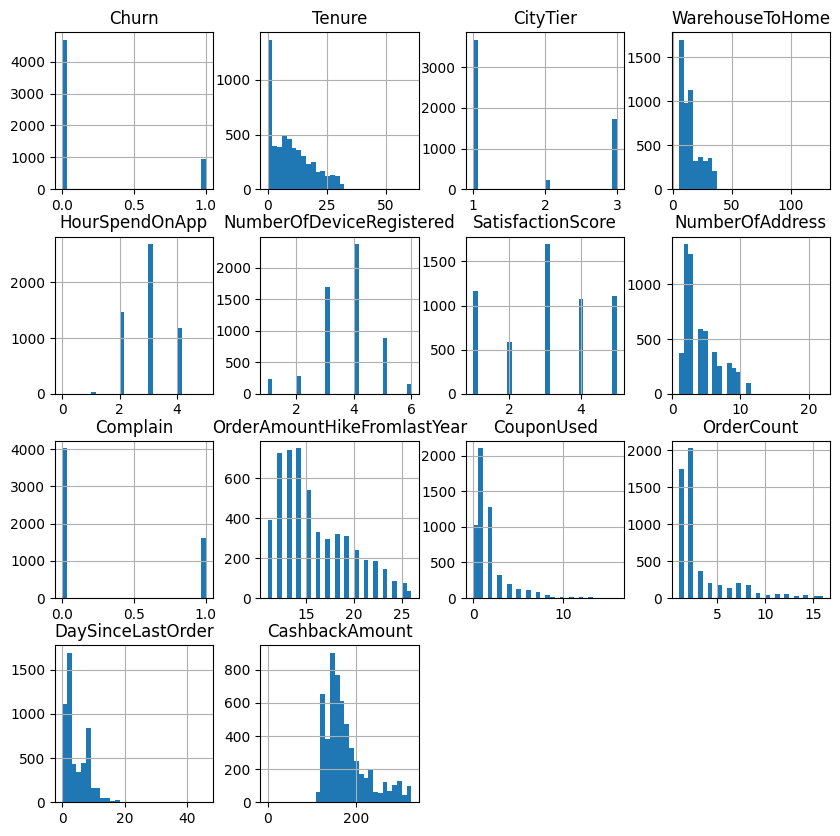

In [22]:
# histogram for each numerical column
df[num_vars].hist(figsize=(10, 10), bins=30)
plt.savefig("./images/histogram_of_numerical_features.png")
plt.show()

Terlihat variable numerik yang ada kebanyakan adalah data deskrit. Data numerik ini kebanyakan tidak mengikuti distribusi normal. Untuk permodelan yang berbasis jarak, beberapa variable perlu untuk dilakukan normalisasi. Untuk data deskrit yang jumlah unique bisa dihitung, maka tidak akan diimplementasikan normalisasi dikarenakan data jumlah uniqe terlalu sedikit untuk dirubah distribusinya.

In [23]:
# check number of unique from numerical variables
df[num_vars].nunique()

Churn                            2
Tenure                          36
CityTier                         3
WarehouseToHome                 34
HourSpendOnApp                   6
NumberOfDeviceRegistered         6
SatisfactionScore                5
NumberOfAddress                 15
Complain                         2
OrderAmountHikeFromlastYear     16
CouponUsed                      17
OrderCount                      16
DaySinceLastOrder               22
CashbackAmount                 220
dtype: int64

In [24]:
# we only normalize variables with more than 10 unique values
num_vars_temp = df[num_vars].nunique()
num_vars_with_more_unique = num_vars_temp[num_vars_temp > 10].index.tolist()

num_vars_with_more_unique

['Tenure',
 'WarehouseToHome',
 'NumberOfAddress',
 'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount']

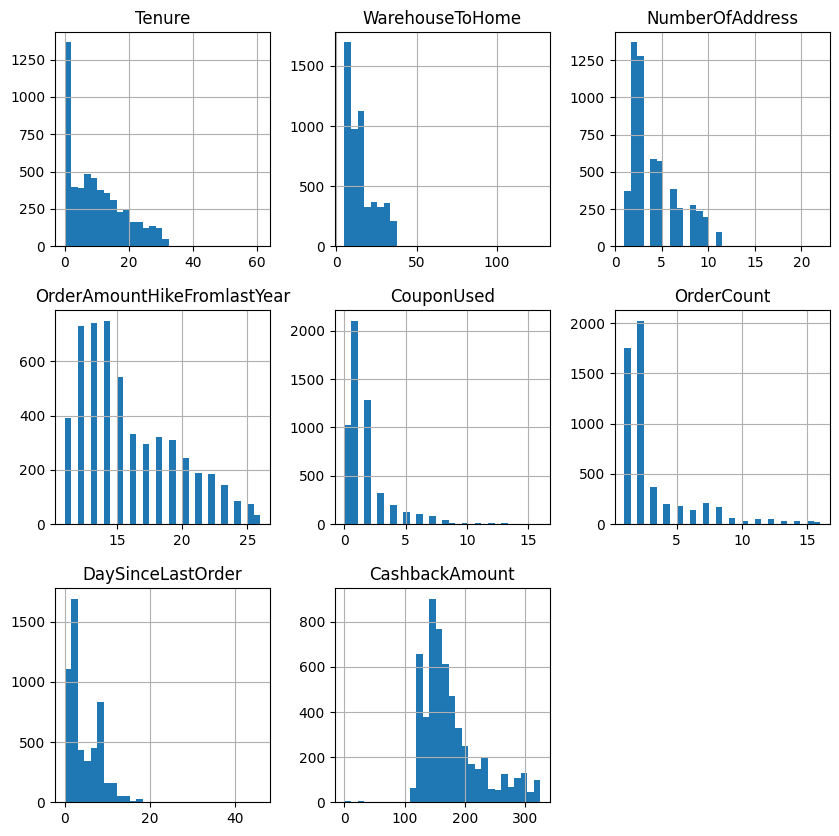

In [25]:
# histogram for more unique numerical columns
df[num_vars_with_more_unique].hist(figsize=(10, 10), bins=30)
plt.show()

## Numerical Transformation

In [26]:
df[num_vars_with_more_unique].describe()

,Tenure,WarehouseToHome,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5366.000000,5379.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,10.189899,15.639896,4.214032,15.707922,1.751023,3.008004,4.543491,177.221492
std,8.557241,8.531475,2.583586,3.675485,1.894621,2.939680,3.654433,49.193869
min,0.000000,5.000000,1.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,9.000000,2.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,9.000000,14.000000,3.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,16.000000,20.000000,6.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,61.000000,127.000000,22.000000,26.000000,16.000000,16.000000,46.000000,325.000000


Transformasi yang akan dicoba adalah `LogTransformation` dan `YeoJohnsonTransformation`. Untuk fitur yang nilai minimum adalah 0, maka `LogTransformation` tidak bisa digunakan karena Logaritma yang menghasilkan 0 tidak terdefinisi. Sehingga kita akan menggunakan `LogTransformation` plus constant.

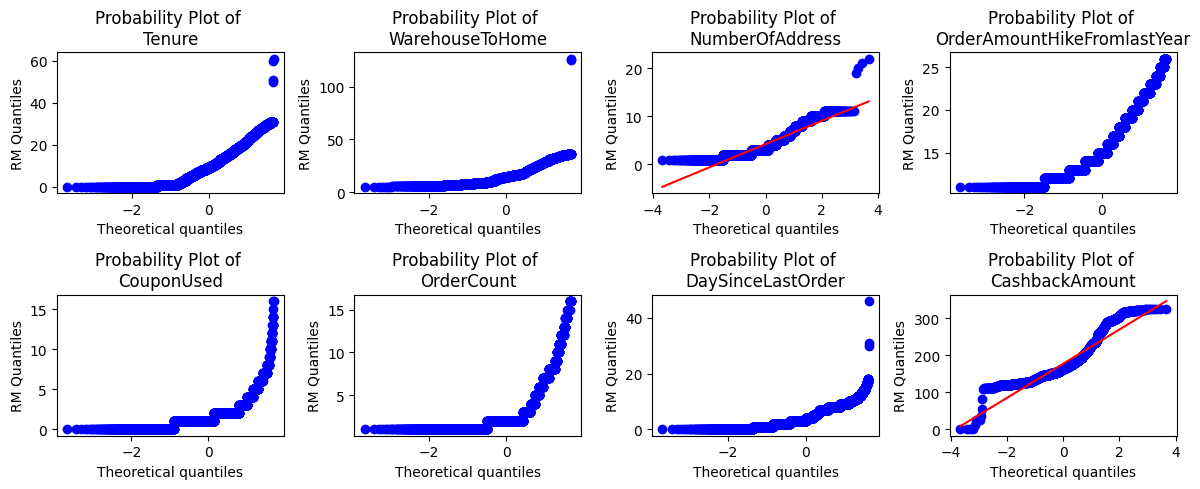

In [31]:
plt.figure(figsize=(12, 5))
for i, var in enumerate(num_vars_with_more_unique):
    plt.subplot(2, 4, i+1)
    stats.probplot(df[var], dist="norm", plot=plt)
    plt.title(f"Probability Plot of \n{var}")
    plt.ylabel("RM Quantiles")
    plt.tight_layout()

plt.savefig("./images/initial_normality.png")
plt.show()  

### LogCpTransformation

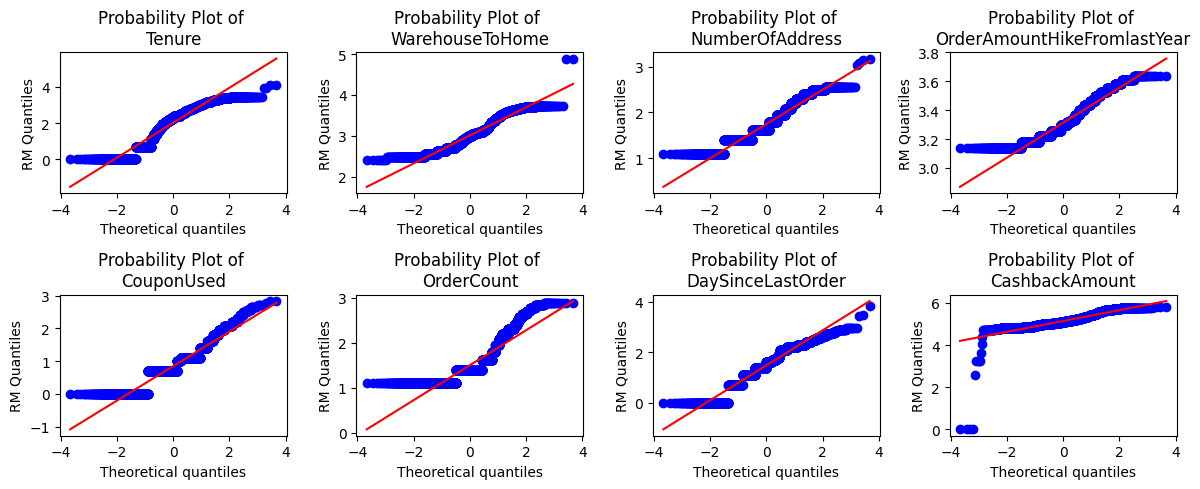

In [32]:
# fill missing value with mean
# transformer cannot transform if missing value exist
fill_value = {col:val for (col, val) in zip(num_vars_with_more_unique, df[num_vars_with_more_unique].mean())}
df_temp = df[num_vars_with_more_unique].fillna(value=fill_value)

# define and fit transformer
log_trans = LogCpTransformer(variables=num_vars_with_more_unique)
log_trans.fit(df_temp)

# transform data
df_temp = log_trans.transform(df_temp)

# visualize
plt.figure(figsize=(12, 5))
for i, var in enumerate(num_vars_with_more_unique):
    plt.subplot(2, 4, i+1)
    stats.probplot(df_temp[var], dist="norm", plot=plt)
    plt.title(f"Probability Plot of \n{var}")
    plt.ylabel("RM Quantiles")
    plt.tight_layout()

plt.savefig("./images/normality_after_LogCp.png")
plt.show()  

### YeoJohnson

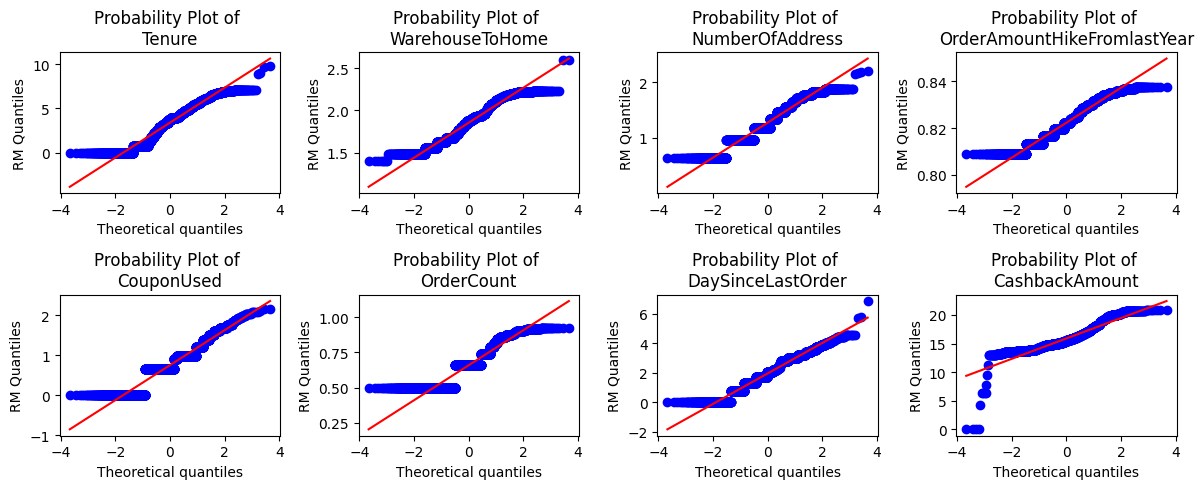

In [33]:
# fill missing value with mean
# transformer cannot transform if missing value exist
fill_value = {col:val for (col, val) in zip(num_vars_with_more_unique, df[num_vars_with_more_unique].mean())}
df_temp = df[num_vars_with_more_unique].fillna(value=fill_value)

# define and fit transformer
yj_trans = YeoJohnsonTransformer(variables=num_vars_with_more_unique)
yj_trans.fit(df_temp)

# transform data
df_temp = yj_trans.transform(df_temp)

# visualize
plt.figure(figsize=(12, 5))
for i, var in enumerate(num_vars_with_more_unique):
    plt.subplot(2, 4, i+1)
    stats.probplot(df_temp[var], dist="norm", plot=plt)
    plt.title(f"Probability Plot of \n{var}")
    plt.ylabel("RM Quantiles")
    plt.tight_layout()

plt.savefig("./images/normality_after_YeoJohnson.png")
plt.show()  

YeoJohnson akan digunakan untuk tranformasi karena memiliki hasil yang paling mendekati distribusi normal.

## Categorical Cardinality

In [ ]:
# check cardinality each columns
df[cat_vars].nunique()

PreferredLoginDevice    3
PreferredPaymentMode    7
Gender                  2
PreferedOrderCat        6
MaritalStatus           3
dtype: int64

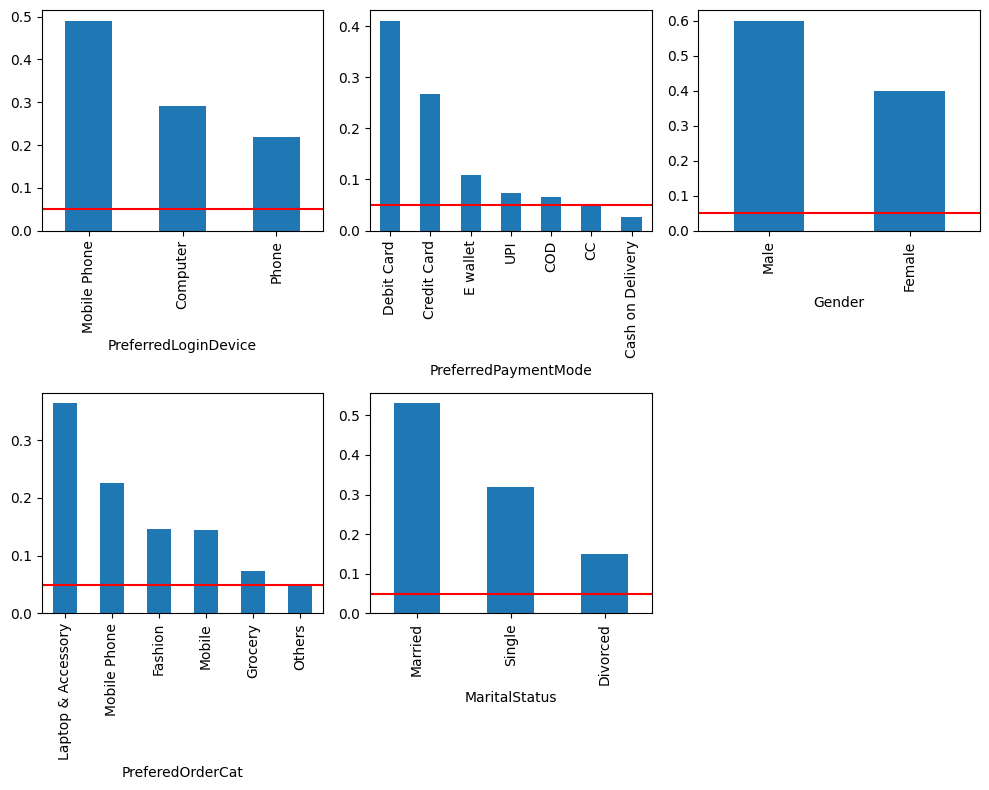

In [34]:
# check rare label each column
for i, var in enumerate(cat_vars):
    ax = plt.subplot(2, 3, i+1)
    df[var].value_counts(normalize=True).plot(kind="bar", ax=ax, figsize=(10, 8))
    plt.axhline(y=0.05, color="red")
    plt.tight_layout()

plt.savefig("./images/categori_proportion.png")
plt.show()

We can simply assume there is no rare label.

# Multivariate Analysis

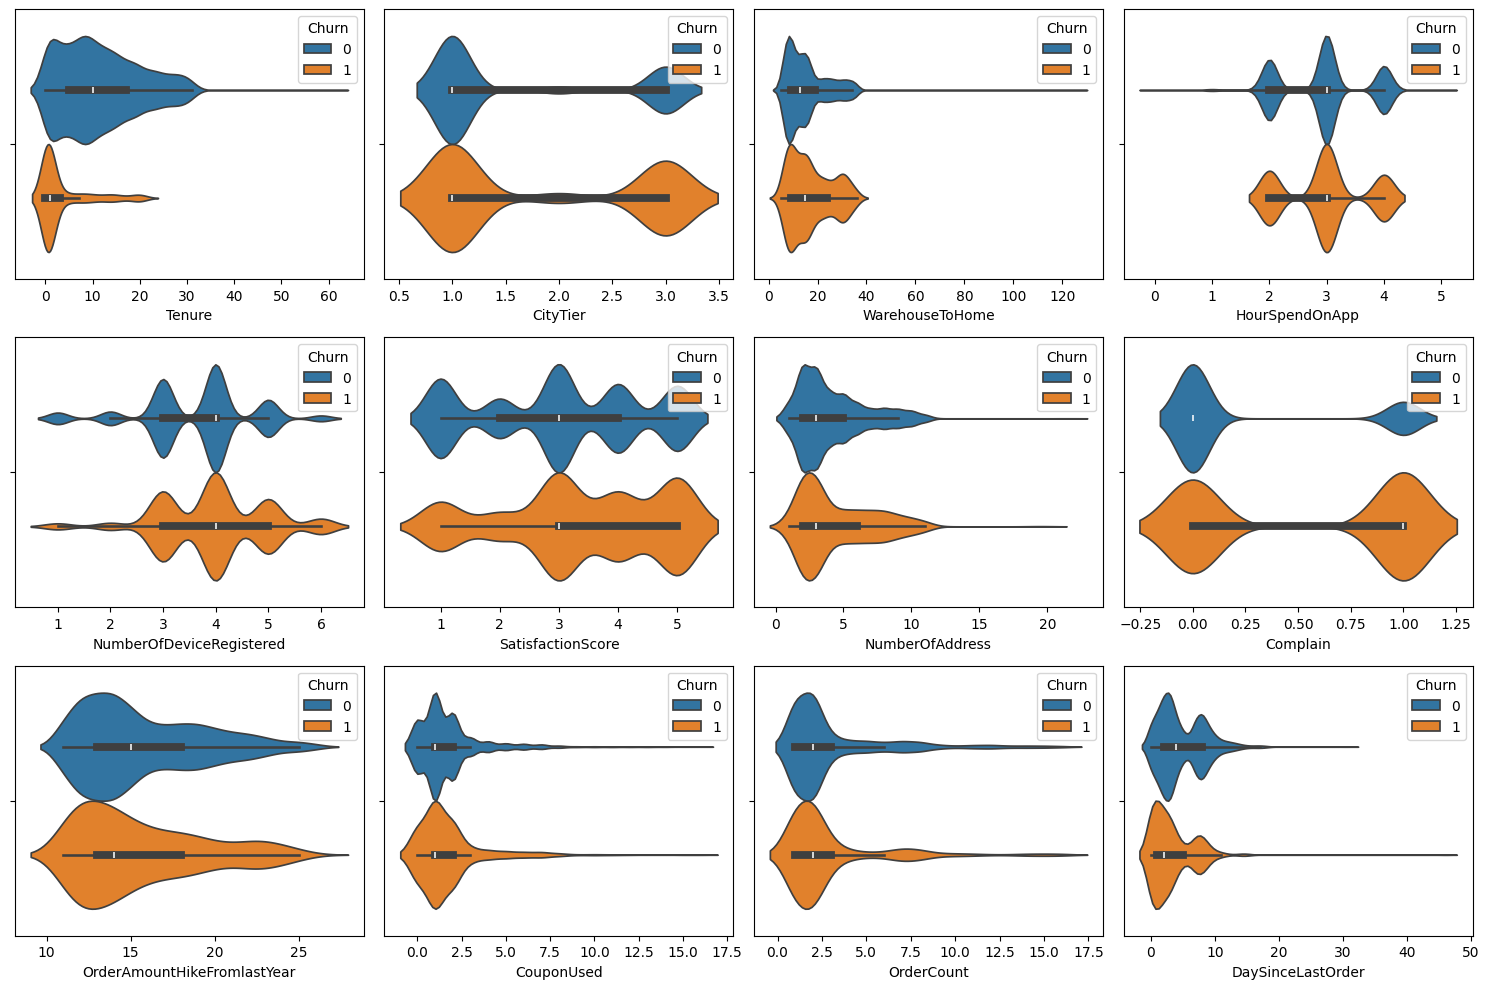

In [50]:
no_target = [var for var in num_vars if var != "Churn"]

fig, ax = plt.subplots(3, 4, figsize=(15, 10))

for var, ax in zip(no_target, ax.flatten()):
    sns.violinplot(data=df, x=var, hue="Churn", ax=ax)
    plt.tight_layout()

plt.savefig("./images/num_x_churn.png")
plt.show()

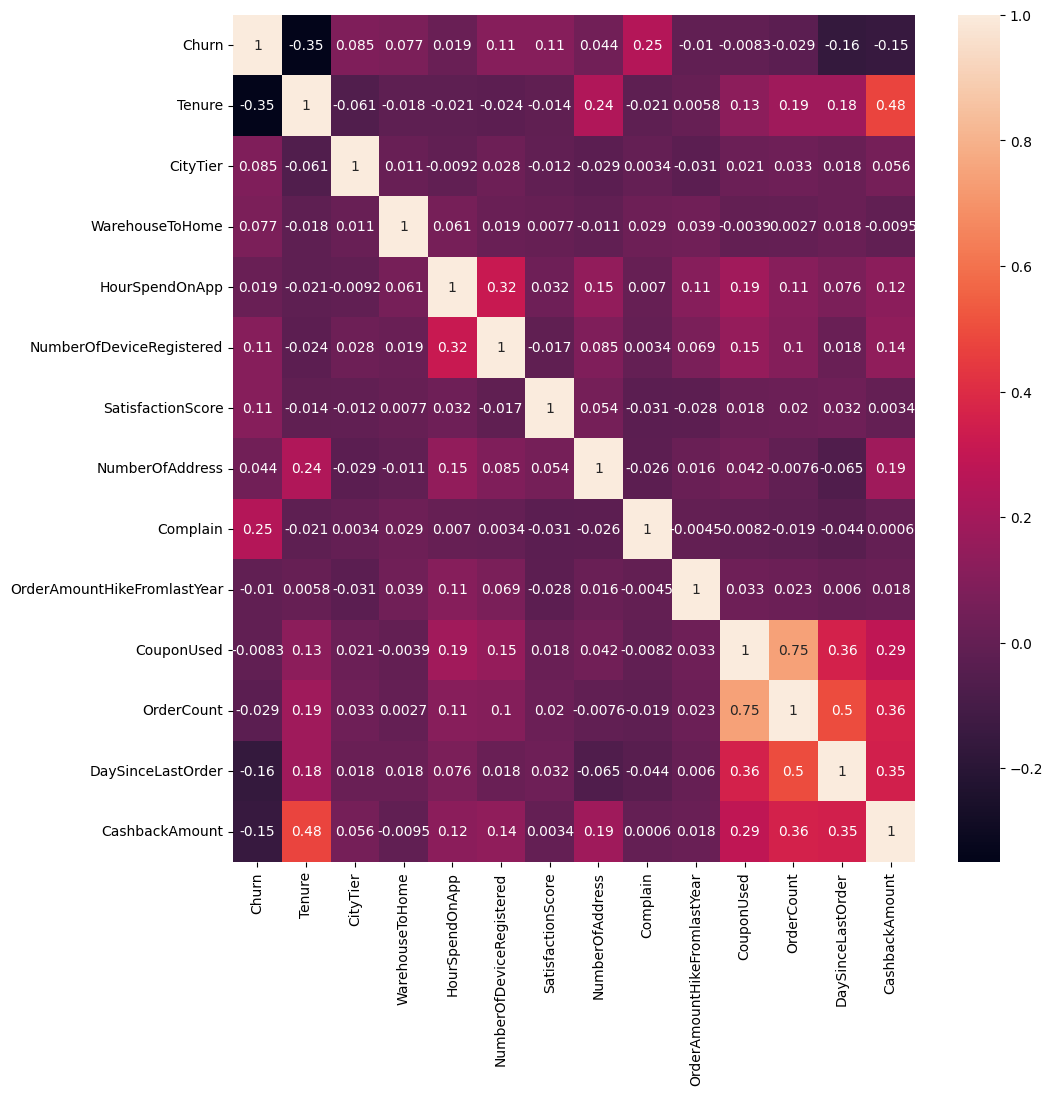

In [52]:
plt.figure(figsize=(11, 11))
sns.heatmap(df[num_vars].corr(), annot=True)
plt.savefig("./images/correlation.png")
plt.show()

In [ ]:
aku adalah superman

SyntaxError: invalid syntax (2028081939.py, line 1)

# Data Preparation

## Check Duplicate Data

In [ ]:
df.duplicated().sum()

556

## Handling Missing Value

In [ ]:
null = df.isna().sum()
null = null[null > 0]/len(df)
null.to_frame(name="% of NaN").join(df[null.index].dtypes.to_frame(name="dtypes"))

,% of NaN,dtypes
Tenure,0.046892,float64
WarehouseToHome,0.044583,float64
HourSpendOnApp,0.045293,float64
OrderAmountHikeFromlastYear,0.047069,float64
CouponUsed,0.045471,float64
OrderCount,0.045826,float64
DaySinceLastOrder,0.054529,float64


In [ ]:
df[null.index].describe()

,Tenure,WarehouseToHome,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder
count,5366.000000,5379.000000,5375.000000,5365.000000,5374.000000,5372.000000,5323.000000
mean,10.189899,15.639896,2.931535,15.707922,1.751023,3.008004,4.543491
std,8.557241,8.531475,0.721926,3.675485,1.894621,2.939680,3.654433
min,0.000000,5.000000,0.000000,11.000000,0.000000,1.000000,0.000000
25%,2.000000,9.000000,2.000000,13.000000,1.000000,1.000000,2.000000
50%,9.000000,14.000000,3.000000,15.000000,1.000000,2.000000,3.000000
75%,16.000000,20.000000,3.000000,18.000000,2.000000,3.000000,7.000000
max,61.000000,127.000000,5.000000,26.000000,16.000000,16.000000,46.000000


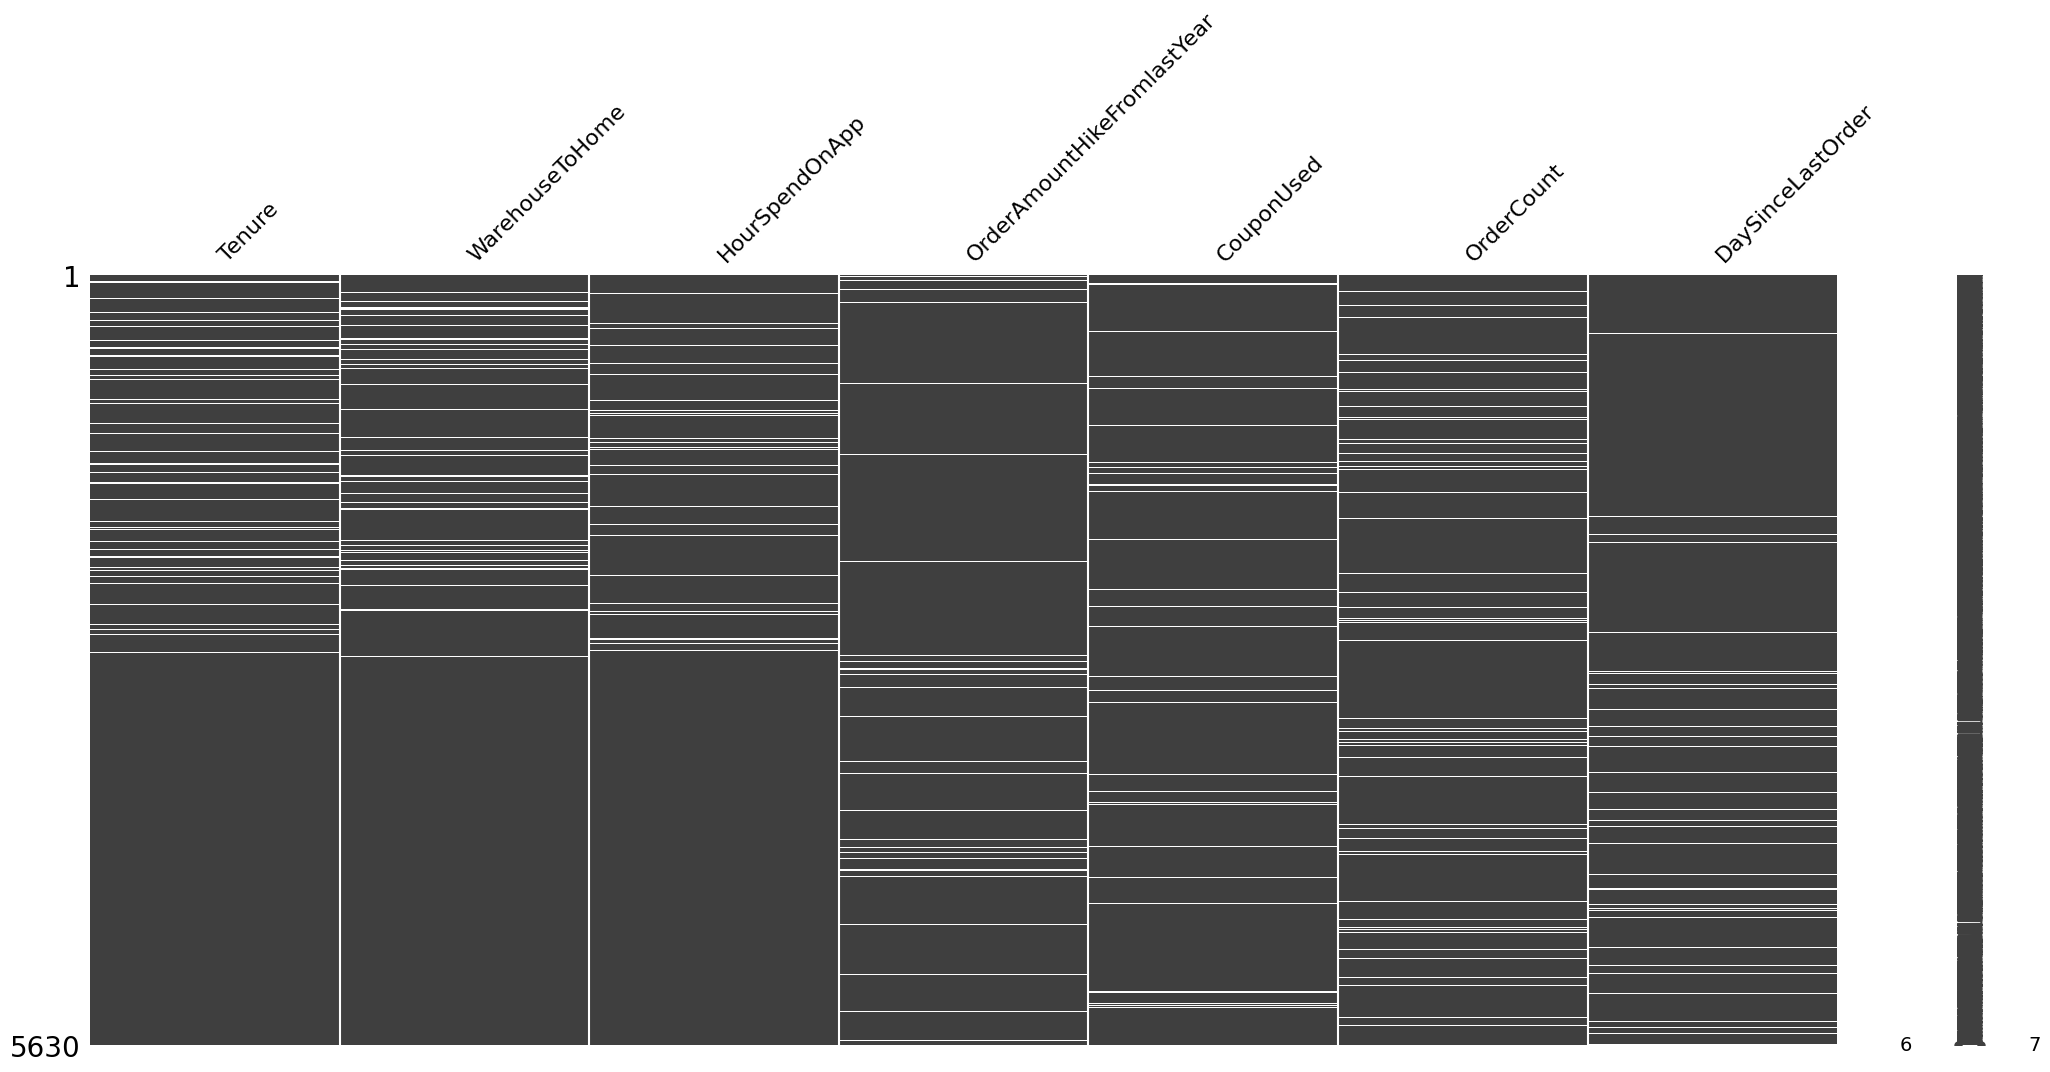

In [ ]:
missingno.matrix(df[null.index])
plt.show()

## Checking Outlier

In [ ]:
def outlier_check(df, var):

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.hist(data=df, x=var)
    plt.title(f"Histogram of {var}")

    plt.subplot(1, 3, 2)
    stats.probplot(df[var], dist="norm", plot=plt)
    plt.ylabel("RM Quantiles")
    

    plt.subplot(1, 3, 3)
    sns.boxplot(y = df[var])
    plt.title(f"Boxplot of {var}")

    plt.show()

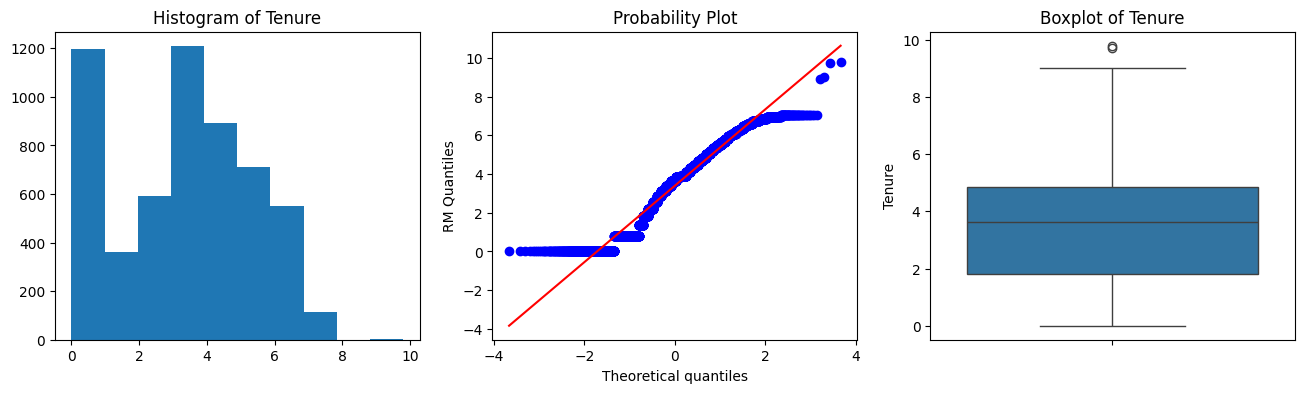

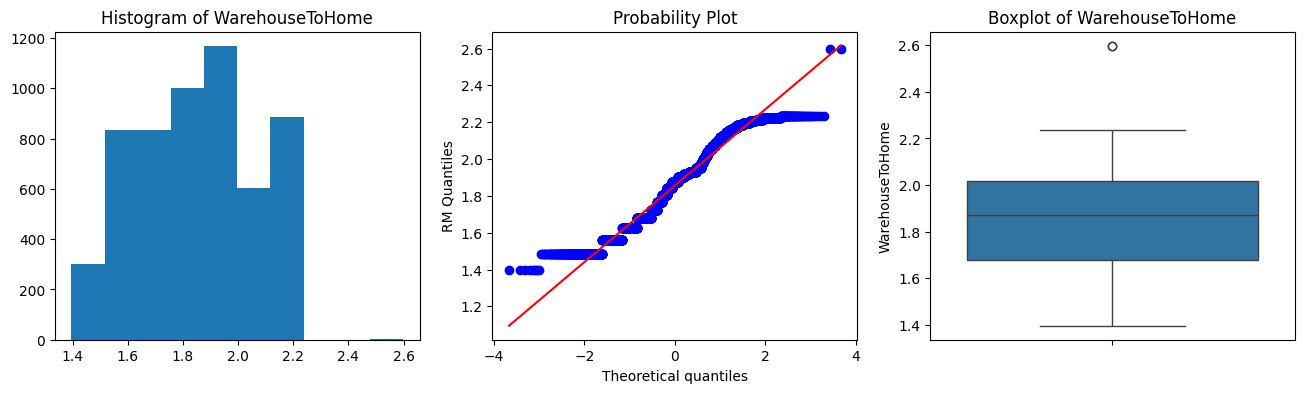

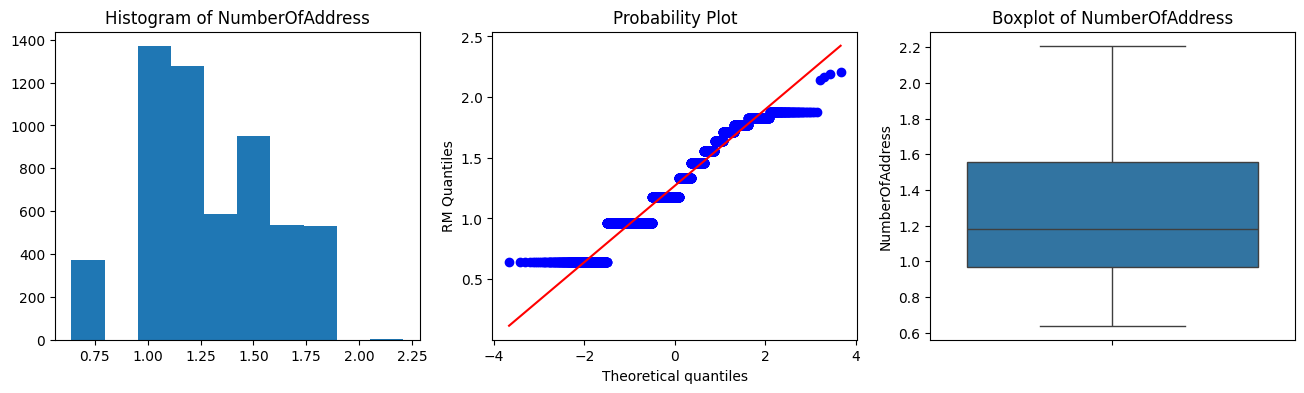

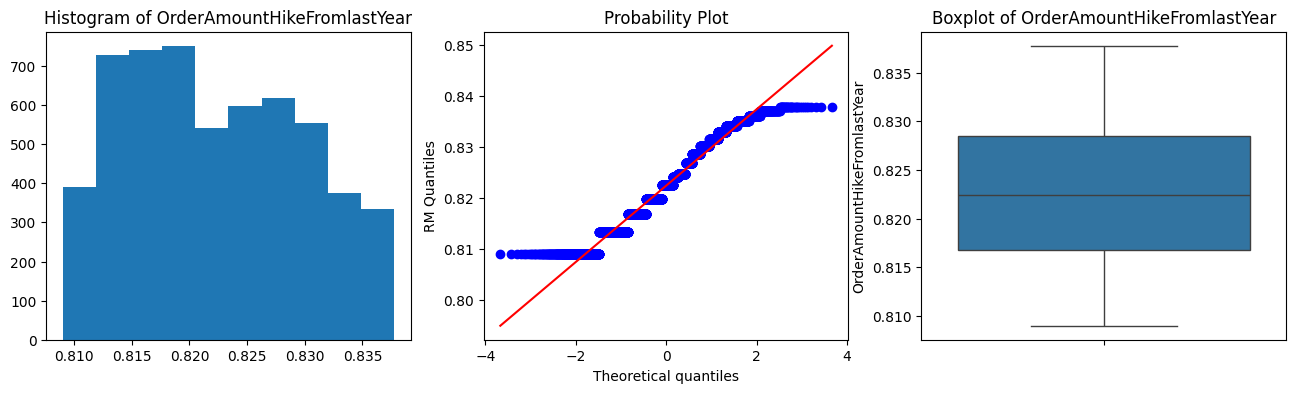

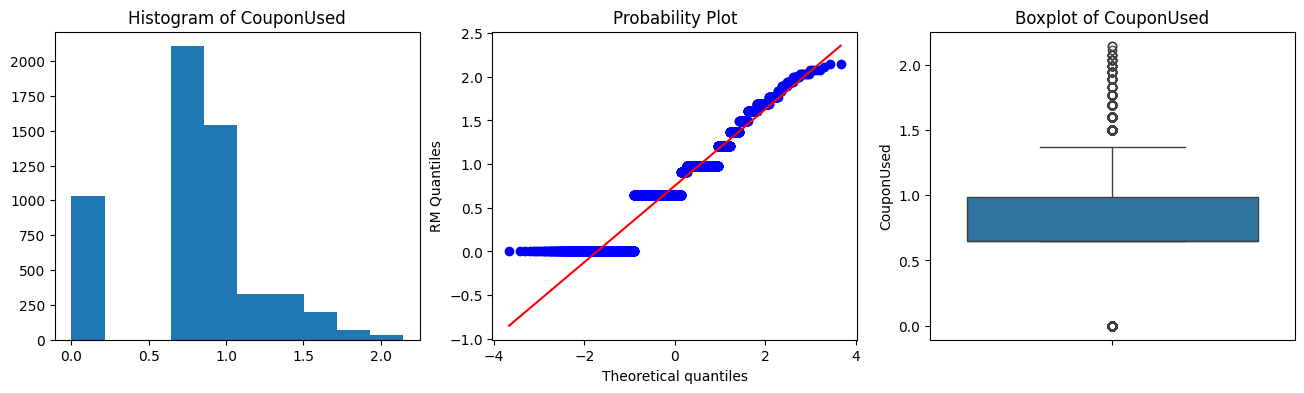

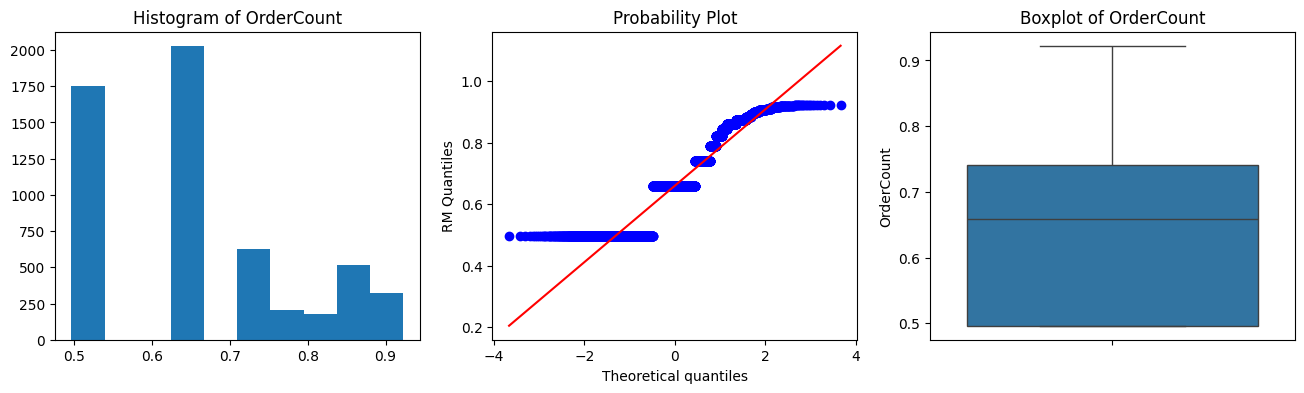

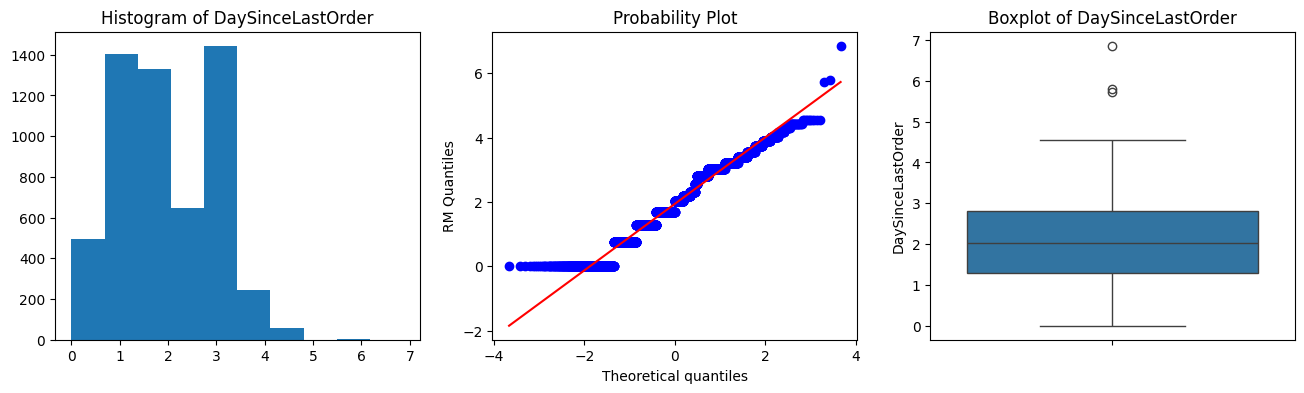

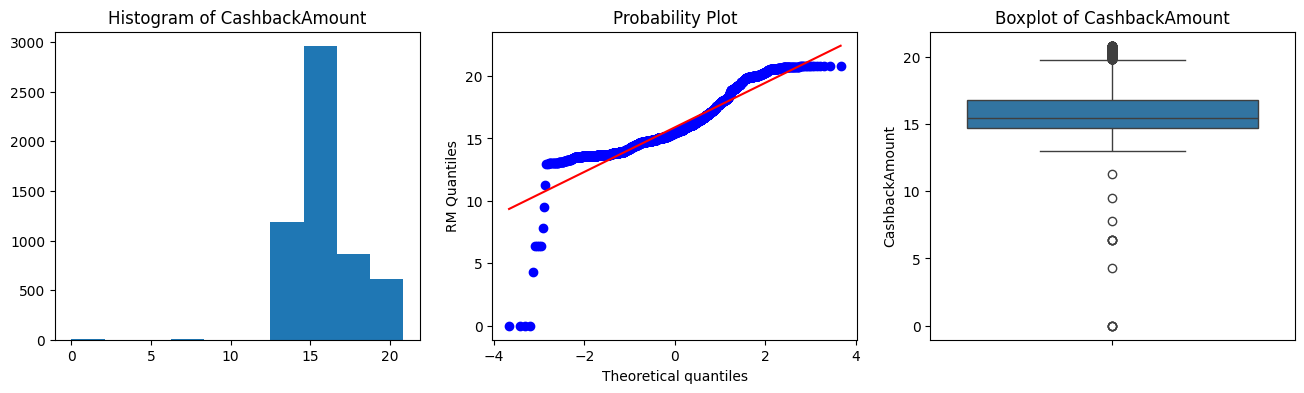

In [ ]:
for var in num_vars_with_more_unique:
    outlier_check(df_temp, var)

# Modelling

In [ ]:
# split data to train and test
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(columns=["Churn"], axis=1),
    df["Churn"],
    stratify = df["Churn"],
    test_size = 0.2
)

## Distance Based Model

In [ ]:
# configuration
NUMERICAL_VARS_WITH_NA_MEAN = [
    'Tenure'
    , 'WarehouseToHome'
    , 'HourSpendOnApp'
    , 'OrderAmountHikeFromlastYear'
    , 'CouponUsed'
    , 'OrderCount'
    , 'DaySinceLastOrder'
]

CATEGORICAL_ENCODING = [
    'PreferredLoginDevice'
    , 'PreferredPaymentMode'
    , 'Gender'
    , 'PreferedOrderCat'
    , 'MaritalStatus'
]

NUMERICAL_TRANSFORMATION_YEO_JOHNSON = [
    'Tenure'
    , 'WarehouseToHome'
    , 'NumberOfAddress'
    , 'OrderAmountHikeFromlastYear'
    , 'CouponUsed'
    , 'OrderCount'
    , 'DaySinceLastOrder'
    , 'CashbackAmount'
]

NUMERICAL_MINMAX_SCALING = [
    'CityTier'
    , 'HourSpendOnApp'
    , 'NumberOfDeviceRegistered'
    , 'SatisfactionScore'
    , 'Complain'
]

In [ ]:
# define scaler
minmax_scaler = ColumnTransformer([
    ("scaler", MinMaxScaler(feature_range=(0, 1)), NUMERICAL_MINMAX_SCALING)
])

# create data preprocessing pipeline
pipe = Pipeline([
    # add missing indicator
    ("mean_missing_indicator", AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA_MEAN)),

    # missing value imputation
    ("mean_imputer", MeanMedianImputer(imputation_method="mean", variables=NUMERICAL_VARS_WITH_NA_MEAN)),

    # categorical encoding
    ("freq_encoding", CountFrequencyEncoder(encoding_method="frequency", variables=CATEGORICAL_ENCODING)),

    # yeo johnson transformation
    ("yeo_transform", YeoJohnsonTransformer(variables=NUMERICAL_TRANSFORMATION_YEO_JOHNSON)),
    
    # minmax scaling
    ("scaling", minmax_scaler)    
])

# set output to pandas
pipe.set_output(transform="pandas")

# fitting to data
pipe.fit(x_train, y_train)

Pipeline(steps=[('mean_missing_indicator',
                 AddMissingIndicator(variables=['Tenure', 'WarehouseToHome',
                                                'HourSpendOnApp',
                                                'OrderAmountHikeFromlastYear',
                                                'CouponUsed', 'OrderCount',
                                                'DaySinceLastOrder'])),
                ('mean_imputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Tenure', 'WarehouseToHome',
                                              'HourSpendOnApp',
                                              'OrderAmountHikeFromlastYear',
                                              'CouponUse...
                ('yeo_transform',
                 YeoJohnsonTransformer(variables=['Tenure', 'WarehouseToHome',
                                                  'NumberOfAddress',
                                                  'OrderAmountHikeFromlastYear',
                                                  'CouponUsed', 'OrderCount',
                                                  'DaySinceLastOrder',
                                                  'CashbackAmount'])),
                ('scaling',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['CityTier', 'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'Complain'])]))])

In [ ]:
# transform
x_train_prep = pipe.transform(x_train)
x_test_prep = pipe.transform(x_test)

In [ ]:
# define model
logreg = LogisticRegression(class_weight="balanced")
knn = KNeighborsClassifier()

In [ ]:
models = [logreg, knn]

score = []
rata = []
std = []

for mod in models:
    skfold = StratifiedKFold(n_splits=5)
    model_cv = cross_val_score(
        mod,
        x_train_prep,
        y_train,
        cv = skfold,
        scoring="recall"
    )

    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

pd.DataFrame({
    "model" : ["Logistic Regression", "KNN"],
    "recall" : rata,
    "sdev" : std
}).set_index("model").sort_values(by="recall", ascending=False)

,recall,sdev
model,,
Logistic Regression,0.634507,0.032565
KNN,0.228207,0.033559


## Tree Based Model

In [ ]:
# configuration
NUMERICAL_VARS_WITH_NA_MEAN = [
    'Tenure'
    , 'WarehouseToHome'
    , 'HourSpendOnApp'
    , 'OrderAmountHikeFromlastYear'
    , 'CouponUsed'
    , 'OrderCount'
    , 'DaySinceLastOrder'
]

CATEGORICAL_ENCODING = [
    'PreferredLoginDevice'
    , 'PreferredPaymentMode'
    , 'Gender'
    , 'PreferedOrderCat'
    , 'MaritalStatus'
]

In [ ]:
# create data preprocessing pipeline
pipe = Pipeline([
    # add missing indicator
    ("mean_missing_indicator", AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA_MEAN)),

    # missing value imputation
    ("mean_imputer", MeanMedianImputer(imputation_method="mean", variables=NUMERICAL_VARS_WITH_NA_MEAN)),

    # categorical encoding
    ("freq_encoding", CountFrequencyEncoder(encoding_method="frequency", variables=CATEGORICAL_ENCODING)), 
])

# set output to pandas
pipe.set_output(transform="pandas")

# fitting to data
pipe.fit(x_train, y_train)

Pipeline(steps=[('mean_missing_indicator',
                 AddMissingIndicator(variables=['Tenure', 'WarehouseToHome',
                                                'HourSpendOnApp',
                                                'OrderAmountHikeFromlastYear',
                                                'CouponUsed', 'OrderCount',
                                                'DaySinceLastOrder'])),
                ('mean_imputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Tenure', 'WarehouseToHome',
                                              'HourSpendOnApp',
                                              'OrderAmountHikeFromlastYear',
                                              'CouponUsed', 'OrderCount',
                                              'DaySinceLastOrder'])),
                ('freq_encoding',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['PreferredLoginDevice',
                                                  'PreferredPaymentMode',
                                                  'Gender', 'PreferedOrderCat',
                                                  'MaritalStatus']))])

In [ ]:
# transform
x_train_prep = pipe.transform(x_train)
x_test_prep = pipe.transform(x_test)

In [ ]:
# define model
dec_tree = DecisionTreeClassifier()
rand_forest = RandomForestClassifier()
xgb = XGBClassifier()

In [ ]:
models = [dec_tree, rand_forest, xgb]

score = []
rata = []
std = []

for mod in models:
    skfold = StratifiedKFold(n_splits=5)
    model_cv = cross_val_score(
        mod,
        x_train_prep,
        y_train,
        cv = skfold,
        scoring="recall"
    )

    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

pd.DataFrame({
    "model" : ["Decision Tree", "Random Forest", "XGBoost"],
    "recall" : rata,
    "sdev" : std
}).set_index("model").sort_values(by="recall", ascending=False)

,recall,sdev
model,,
XGBoost,0.837713,0.014974
Decision Tree,0.796724,0.038243
Random Forest,0.749285,0.033979


## Hyperparameter Tuning

In [ ]:
# Define the hyperparameter grid
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create an XGBoost classifier
xgb = XGBClassifier()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=250,  # Number of random combinations to try
    scoring='recall',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1  # Use all available cores for parallel processing
)

random_search.fit(x_train_prep, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='recall', verbose=1)

In [ ]:
# Print the best parameters and corresponding accuracy
print("Best Parameters: ", random_search.best_params_)
print("Best recall: ", random_search.best_score_)

Best Parameters:  {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best recall:  0.844327291739282


In [ ]:
# Get the best parameters
best_params = random_search.best_params_

# Create an XGBoost classifier with the best parameters
best_xgb = XGBClassifier(**best_params)

# Fit the model with the best parameters to the entire training set
best_xgb.fit(x_train_prep, y_train)

# predict
y_test_pred = best_xgb.predict(x_test_prep)

print(recall_score(y_test, y_test_pred))

0.8789473684210526


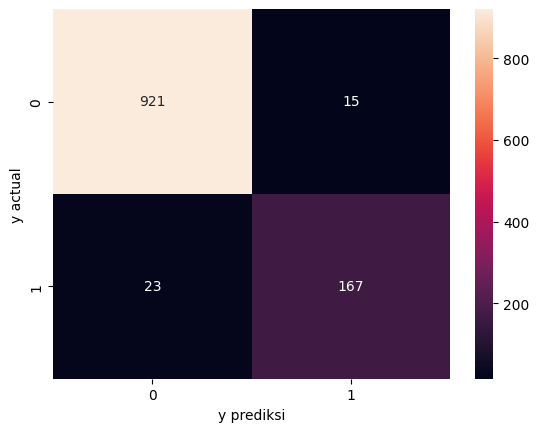

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d")
plt.ylabel("y actual")
plt.xlabel("y prediksi")
plt.show()